## Predict house prices  


There is a dataset with 79 explanatory variables describing (almost) every aspect of residential homes.  

  
**Goal:**  
To predict the final price of each home.  
  

**Metric:**  
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [1]:
pip install ydf -U

In [2]:
pip install phik

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ydf
import phik
from sklearn.model_selection import train_test_split

In [4]:
# set the constant
RANDOM_STATE = 12345

In [5]:
df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
submission_df = pd.read_csv('/content/sample_submission.csv')

### EDA

In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# check/count duplicates
df.duplicated().sum()

0

Analysis of the target (`SalePrice`)

In [9]:
df.SalePrice.describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


<ipython-input-10-36cb2cf793ba>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.SalePrice);


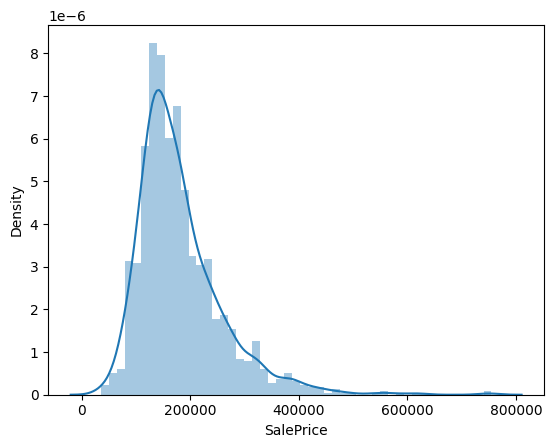

In [10]:
sns.distplot(df.SalePrice);

In [11]:
# since the metric evaluates a logarithm of the predicted value, we calculate a logarithm:
df['SalePrice_log'] = np.log(df['SalePrice'])

<ipython-input-12-6f23826805a6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.SalePrice_log)


<Axes: xlabel='SalePrice_log', ylabel='Density'>

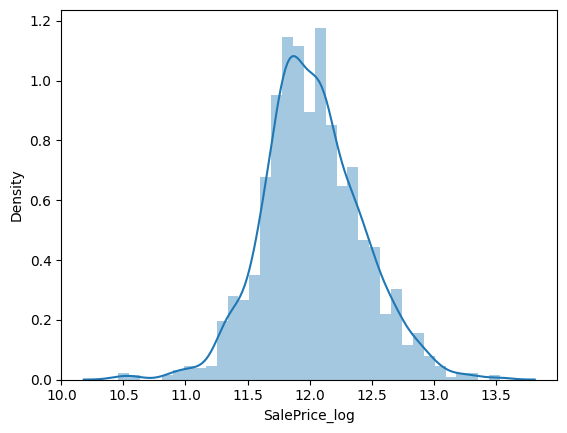

In [12]:
# distribution of the logarithmic value of the target
sns.distplot(df.SalePrice_log)

Logarithmic values of `SalePrice` form a normal distribution. A distribution of absolute values of `SalePrice` slightly shifted left and outliers to the right are observed.

In [13]:
(
    df[['SalePrice', 'SalePrice_log']]
    .quantile([ 0.01, 0.05,.5, 0.95, .99])
    .style.format("{:,.2f}")
)

,SalePrice,SalePrice_log
0.010000,"61,815.97",11.03
0.050000,"88,000.00",11.39
0.500000,"163,000.00",12.00
0.950000,"326,100.00",12.69
0.990000,"442,567.01",13.00


There are less than 1% houses sold for < `61815` and less than 1% houses sold for > `442567`.

##### Numeric features

In [14]:
# we exclude `Id` and `SalePrice_log` from analysis of a numeric features
numeric_features = df.drop(['Id', 'SalePrice_log'], axis=1).select_dtypes(include=[float, int])

We look at the top 10 numeric features which correlate with target (`SalePrice`) the most and plot correlation heatmap.

In [15]:
correlation_num_features = numeric_features.corr()
print (correlation_num_features['SalePrice'].sort_values(ascending=False)[:10])


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


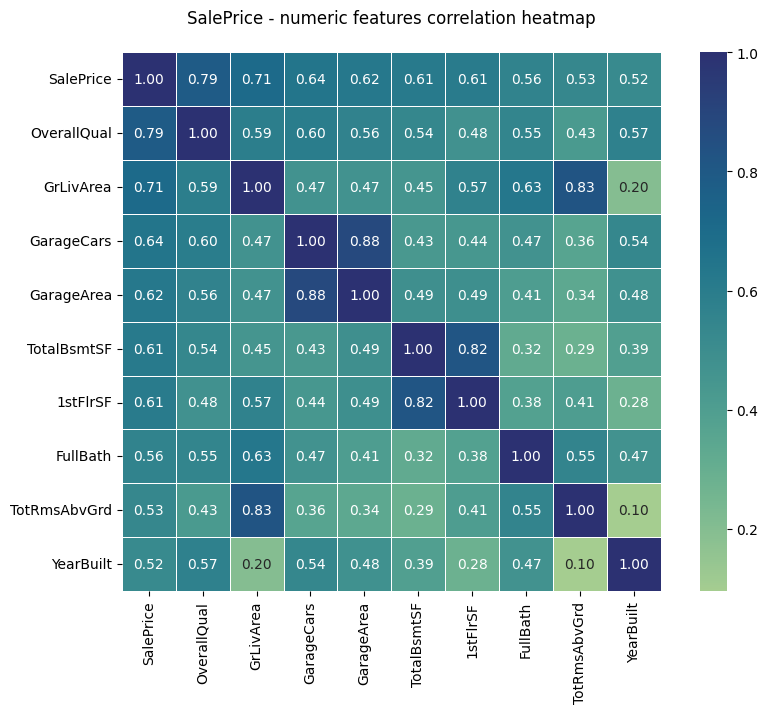

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    df[correlation_num_features["SalePrice"].sort_values(ascending=False).index[:10]].corr(),
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    square=True,
    cmap="crest",
    linewidths=.5,
).set_title("SalePrice - numeric features correlation heatmap" + "\n", fontsize=12);

Let's plot some of the num feature - target correlation.

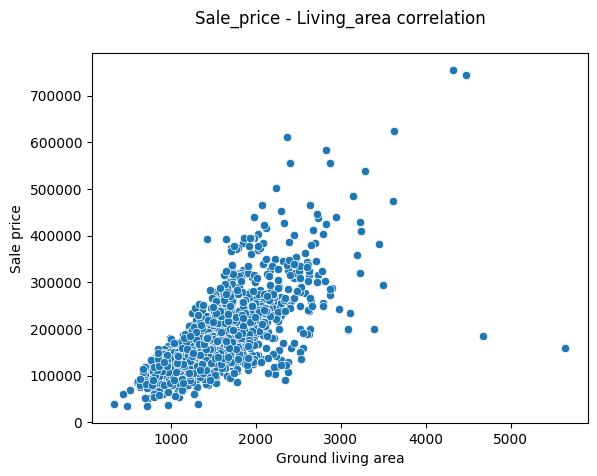

In [17]:
sns.scatterplot(x=df.GrLivArea, y=df.SalePrice)
plt.ylabel('Sale price')
plt.xlabel('Ground living area')
plt.title('Sale_price - Living_area correlation' + '\n');

In [18]:
(
    df[['GrLivArea']]
    .quantile([ 0.01, 0.03,.5, 0.97, .99])
    .style.format("{:,.2f}")
)

,GrLivArea
0.010000,692.18
0.030000,796.00
0.500000,"1,464.00"
0.970000,"2,633.23"
0.990000,"3,123.48"


Less than 1% of houses have `GrLivArea` (Above grade (ground) living area square feet) < 692 and less than 1% of houses have `GrLivArea` > 3123.

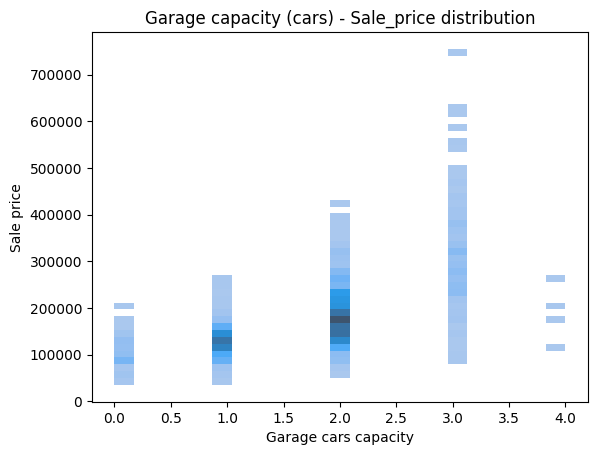

In [19]:
sns.histplot(x=df.GarageCars, y=df.SalePrice)
plt.ylabel('Sale price')
plt.xlabel('Garage cars capacity')
plt.title('Garage capacity (cars) - Sale_price distribution');

There are very few houses with garage for 4 cars. The presence of a garage and the number of cars it can accommodate increase the `SalePrice`. This applies to garages for 1-3 cars. A garage for 4 cars doesn't affect the `SalePrice`.

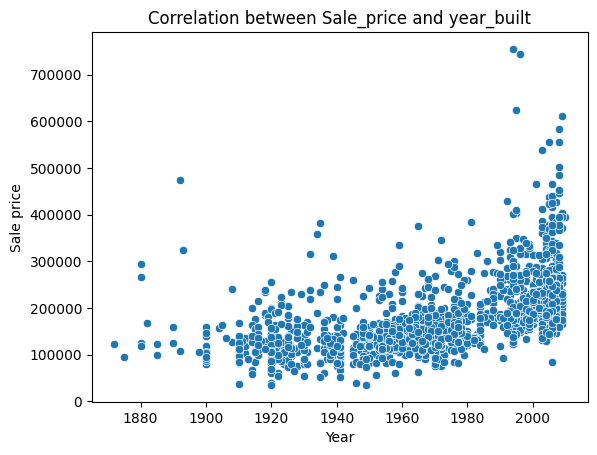

In [20]:
sns.scatterplot(x=df.YearBuilt, y=df.SalePrice)
plt.ylabel('Sale price')
plt.xlabel('Year')
plt.title('Correlation between Sale_price and year_built');

Newly built houses cost more.

##### Categorical values

In [21]:
categorical_features = df.select_dtypes(exclude=[np.number])
categorical_features.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [22]:
# add `SalePrice` column to categorical features dataframe to check correlation between the target and categorical features
cat_feature_target = categorical_features.copy()
cat_feature_target['SalePrice']=df['SalePrice']

In [23]:
# correlation between the target and categorical features, top 10
cat_feature_target.phik_matrix().sort_values(by='SalePrice', ascending=False)['SalePrice'].head(10)

interval columns not set, guessing: ['SalePrice']


,SalePrice
SalePrice,1.000000
Neighborhood,0.687896
Alley,0.683165
ExterQual,0.675875
KitchenQual,0.661993
BsmtQual,0.655659
PoolQC,0.625961
GarageFinish,0.570523
CentralAir,0.543913
HeatingQC,0.514985


`Neighborhood`, `Alley`, exterial materal, `PoolQC` highly correlate with house sale price.

##### Null values

In [24]:
def pass_value_barh(df):
    (df.isna().mean() * 100).to_frame().rename(columns={0: "space"}).query(
        "space > 0"
    ).sort_values(by="space", ascending=True).plot(
        kind="barh", figsize=(19, 6), legend=False, xlabel='Percents', fontsize=14, grid=True,
    ).set_title(
        "Percentage of null values" + "\n", fontsize=20
    )

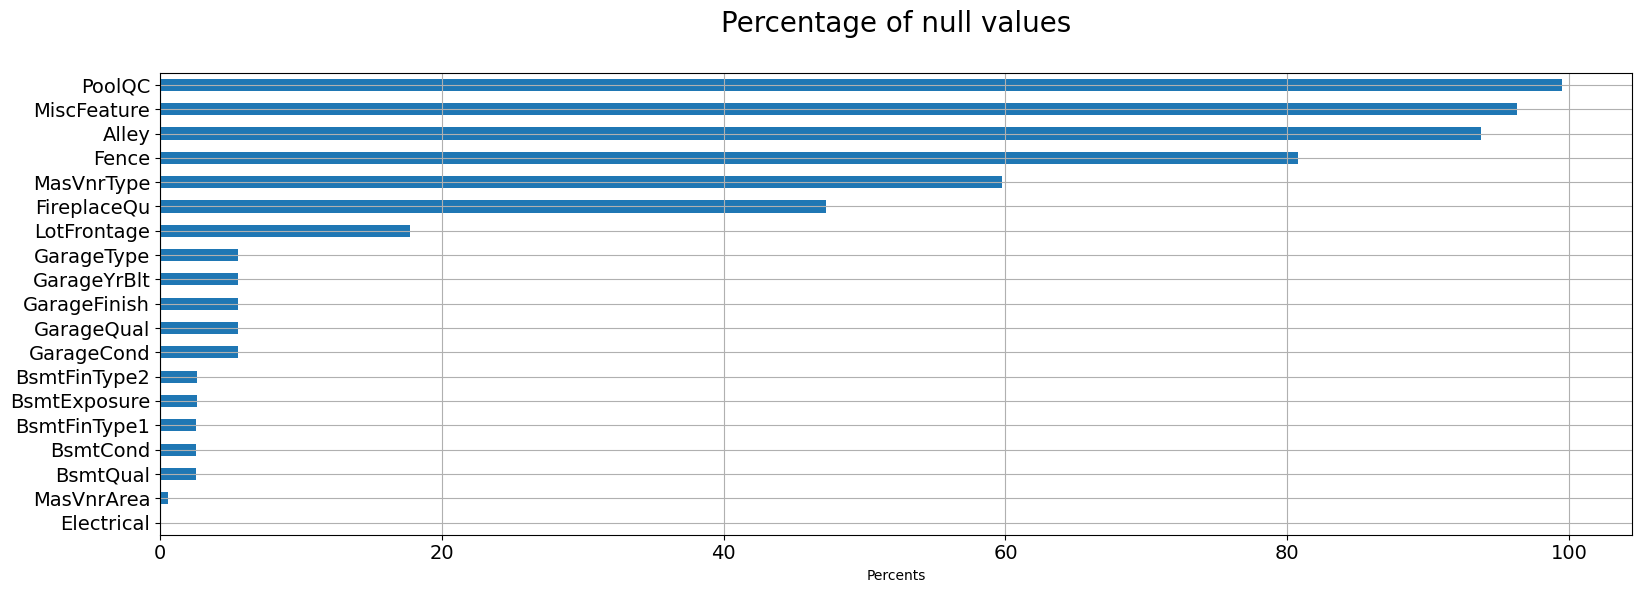

In [25]:
pass_value_barh(df)

There are ~95% of values missed for `PoolQC`, `MiscFeature`,`Alley`, etc. We will fill some of them. The rest of missing data will be handled by a model.  

##### Prepare the dataset

We drop `Id`column as it is not useful for a machine learning model. We drop `SalePrice` as `SalePrice_log` will be used as target for a model learning.


In [26]:
df.drop(['Id', 'SalePrice'], axis=1, inplace=True)

In [27]:
# assume that `PoolQC` is N/A in case the lot doesn't have a pool, i e the lot's `PoolArea` is 0.
# Let's fill this categorical feature with 'no_pool'
df.loc[df['PoolArea'] == 0, 'PoolQC'] = df['PoolQC'].fillna('no_pool')

In [28]:
# assume that `MiscFeature` is N/A in case the lot doesn't have any.
# fill N/A of this categorical feature with 'no_feature'
df['MiscFeature'] = df['MiscFeature'].fillna('no_feature')

In [29]:
# assume that `Fence` is N/A in case the lot doesn't have any.
# fill N/A of this categorical feature with 'no_fence'
df['Fence'] = df['Fence'].fillna('no_fence')

In [30]:
# assume that `FireplaceQu` is N/A in case the lot doesn't have any.
# fill N/A of this categorical feature with 'no_fireplace'
df['FireplaceQu'] = df['FireplaceQu'].fillna('no_fireplace')

In [31]:
# Assume if linear feet of street connected to property is N/A, then the property has no connection to street
df['LotFrontage'] = df['LotFrontage'].fillna(0)

In [32]:
# assume that Masonry veneer type is N/A in case the lot doesn't have veneer.
df.loc[df['MasVnrArea'] == 0, 'MasVnrType'] = df['MasVnrType'].fillna('no_veneer')


In [33]:
# as per dataset description N/A in `Alley` means `No alley access to the property`
df['Alley'] = df['Alley'].fillna('no_alley_access')

In [34]:
# as per dataset description N/A in `GarageType` means `No garage`
df['GarageType'] = df['GarageType'].fillna('no_garage')

In [35]:
# fill missing values in columns describing a garage
df.loc[df['GarageCars'] == 0, 'GarageType'] = df['GarageType'].fillna('no_garage')
df.loc[df['GarageCars'] == 0, 'GarageYrBlt'] = df['GarageYrBlt'].fillna(1000) # numerical feature
df.loc[df['GarageCars'] == 0, 'GarageFinish'] = df['GarageFinish'].fillna('no_garage')
df.loc[df['GarageCars'] == 0, 'GarageQual'] = df['GarageQual'].fillna('no_garage')
df.loc[df['GarageCars'] == 0, 'GarageCond'] = df['GarageCond'].fillna('no_garage')

In [36]:
df_model = df.query('3124 >= GrLivArea >= 692')
df_model.shape

(1430, 80)

In [37]:
# check size of the dataset comparing to the size of initial dataset
df_model.shape[0]/df.shape[0]*100

97.94520547945206

We have dropped ~2% of data from initial dataset, which is acceptable.

### Model training

In [38]:
# Split to train and test datasets

X_train, X_test = train_test_split(
    df_model, test_size=0.3, random_state=RANDOM_STATE
)

#check train and test sets size
display(
    X_train.shape,
    X_test.shape,
   )

(1001, 80)

(429, 80)

We did not specify input features, so all the columns are used as input features. The type of features is automatically detected and ingested.  
Let's train a gradient boosted trees model using tuned values for some of the hyper-parameters.

In [39]:
tuner = ydf.RandomSearchTuner(num_trials=50)
tuner.choice("shrinkage", [0.2, 0.1, 0.05])
tuner.choice("subsample", [1.0, 0.9, 0.8])
tuner.choice("max_depth", [3, 4, 5, 6])

In [40]:
model = ydf.GradientBoostedTreesLearner(
    label="SalePrice_log",
    task=ydf.Task.REGRESSION,
    num_trees=100,
    tuner=tuner,
).train(X_train)

model

Train model on 1001 examples
Model trained in 0:00:33.662397


In [41]:
model.describe()

trial,score,duration,shrinkage,subsample,max_depth
17,-0.107811,20.5568,0.2,0.8,3
14,-0.10802,18.2564,0.1,0.8,5
33,-0.109496,31.1747,0.2,0.9,5
28,-0.110468,27.4045,0.1,0.9,4
21,-0.110824,23.3018,0.1,0.8,3
2,-0.112243,6.99152,0.05,0.8,6
7,-0.112892,12.0678,0.1,1,4
27,-0.114896,26.8698,0.2,0.9,4
4,-0.115012,9.98694,0.05,0.9,6
26,-0.115202,26.4004,0.2,0.9,3


In [42]:
model.evaluate(X_test)

Evaluation()

<Axes: xlabel='SalePrice_log'>

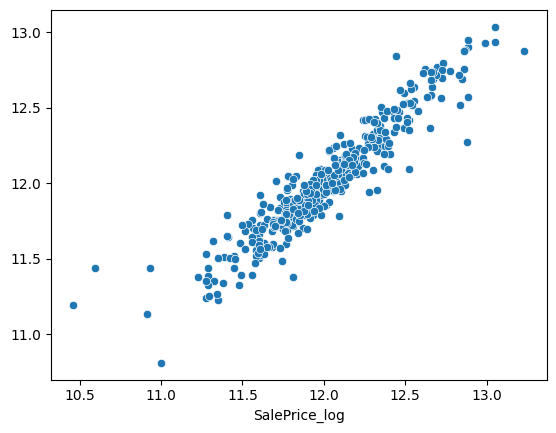

In [43]:
# correlation between predicted target values and the real values (X_test)
sns.scatterplot(x=X_test['SalePrice_log'], y=model.predict(X_test).flatten())

### Submission

In [44]:
prediction = model.predict(test_df)
prediction

array([11.735817 , 12.0304365, 12.1947975, ..., 11.993376 , 11.824383 ,
       12.155672 ], dtype=float32)

In [45]:
submission_df["SalePrice"] = np.exp(prediction)
submission_df.head(3)

,Id,SalePrice
0,1461,124968.492188
1,1462,167784.640625
2,1463,197757.640625


In [46]:
submission_df.to_csv('submission.csv', index=False)

### Conclusion

To predict target we trained YDF gradient boosted decision trees model with tuned hyper-parameters. Dataset was splitted into train and test subsets in a ratio 70:30. The metric was evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.) For test subset RMSE: 0.131265.  
The most important features in the model are: OverallQuality, Neigborhood, GrlivingArea.
Predicted results were converted from logarithmic back to normal scale.
